In [84]:
import pandas as pd
import numpy as np
from anomalous_edited import *
from function import *

df = pd.read_csv('forestfires_with_fwi_bui.csv')

#Test to see which one is better
#df_normalized = normalization_zscore(df)
df_normalized = normalization_range(df)

#number of data points
nn = df.shape[0]
#number of features
mm = df.shape[1]

print("Number of data points: ", nn)
print("Number of features: ", mm)

Number of data points:  517
Number of features:  13


In [85]:
# Calculate global statistics
me = [np.mean(df.iloc[:, j]) for j in range(mm)]
mmax = [np.max(df.iloc[:, j]) for j in range(mm)]
mmin = [np.min(df.iloc[:, j]) for j in range(mm)]
ranges = []
normalization = 0  # set to 1 to ignore feature ranges, 0 otherwise
for j in range(mm):
    if normalization:
        ranges.append(1)
    else:
        rng = mmax[j] - mmin[j]
        if rng == 0:
            print("Variable num {} is constant!".format(j))
            rng = 1
        ranges.append(rng)

sy = np.divide((df - me), ranges)
sY = np.array(sy)
d = np.sum(sY * sY)   # total data scatter of normalized data

print("Mean: ", me)
print("Max: ", mmax)
print("Min: ", mmin)
print("Ranges: ", ranges)

Mean:  [4.669245647969052, 4.299806576402321, 90.64468085106384, 110.87234042553192, 547.9400386847195, 9.021663442940039, 18.88916827852998, 44.28820116054158, 4.017601547388782, 0.021663442940038684, 12.847292069632493, 142.19574468085105, 30.67311411992263]
Max:  [9, 9, 96.2, 291.3, 860.6, 56.1, 33.3, 100, 9.4, 6.4, 1090.84, 315.6, 90.4]
Min:  [1, 2, 18.7, 1.1, 7.9, 0.0, 2.2, 15, 0.4, 0.0, 0.0, 2.2, 0.0]
Ranges:  [8, 7, 77.5, 290.2, 852.7, 56.1, 31.099999999999998, 85, 9.0, 6.4, 1090.84, 313.40000000000003, 90.4]


In [86]:
x = df.values.astype(np.float32)
remains = list(range(nn))
threshold = 1
ds_threshold = 5 # threshold for cluster contribution
numberC = 0
ancl = []


while len(remains) > 0:

    # Step 1: Compute distance to the global mean
    distance = dist(x, remains, ranges, me)

    # Step 2: Choose the most distant point as centroid
    ind = np.argmax(distance)
    index = remains[ind]
    centroid = x[index, :]

    # Step 3: Run the anomalous pattern algorithm
    cluster, centroid = anomalousPattern(x, remains, ranges, centroid, me)

    if len(cluster) == 0:
        break

    # Step 4: Compute standardized centroid and contribution
    censtand = np.divide((np.asarray(centroid) - me), np.asarray(ranges))
    dD = np.sum(censtand * censtand.T * len(cluster) * 100 / d)

    # Step 5: Store the result
    ancl.append({
        'cluster': cluster,
        'centroid': censtand,
        'dD': dD
    })

    # Step 6: Update remains
    remains = np.setdiff1d(remains, cluster)
    numberC += 1

print(len(ancl))

17


In [87]:
small_clusters = [ac for ac in ancl if ac['dD'] < ds_threshold]
print(len(small_clusters))

large_clusters = [ac for ac in ancl if ac['dD'] >= ds_threshold]
print(len(large_clusters))

14
3


In [88]:
# Step 1: Identify clusters with contributions below the threshold
small_clusters = [ac for ac in ancl if ac['dD'] < ds_threshold]

# Step 2: Reassign points from small clusters to larger clusters
for small_cluster in small_clusters:
    cluster_points = small_cluster['cluster']
    small_centroid = small_cluster['centroid']
    
    # Find the clusters with contribution above the threshold
    large_clusters = [ac for ac in ancl if ac['dD'] >= ds_threshold]
    
    # Reassign each point in the small cluster
    for point_idx in cluster_points:
        # Calculate the distances to centroids of large clusters
        distances_to_large_clusters = [np.linalg.norm(x[point_idx] - ac['centroid']) for ac in large_clusters]
        
        # Find the closest centroid
        closest_cluster_idx = np.argmin(distances_to_large_clusters)
        closest_cluster = large_clusters[closest_cluster_idx]
        
        # Add the point to the closest cluster
        closest_cluster['cluster'].append(point_idx)
        
        closest_cluster['centroid'] = np.mean(x[closest_cluster['cluster']], axis=0)  # Update centroid for the whole cluster
        # Optionally, recalculate contribution (dD) if needed
        censtand = np.divide(np.asarray(closest_cluster['centroid']) - me, ranges)
        dD = np.sum(censtand * censtand.T * len(closest_cluster['cluster']) * 100 / d)
        closest_cluster['dD'] = dD
        

    # Remove the points from the small cluster
    ancl.remove(small_cluster)
    
#Standardized the centroids of the large clusters
for ac in ancl:
    ac['centroid'] = np.divide(ac['centroid'] - me, ranges)

# The new centroids dont seem to have been calculated properly, the values seem to high

# TODO: investigate this ^^^^^^

# OK MAYBE ITS CORRECT

I dont think its standardized

TODO: investigate this ^^^^^^

In [89]:
# Print out the clusters and their standardized centroids
if len(ancl) == 0:
    print('No clusters found after reassignment!')
else:
    for i, ac in enumerate(ancl):
        print(f"Cluster {i + 1}:")
        print("  Size:", len(ac['cluster']))
        #print("  Centroid (standardized):", np.round(ac['centroid'], 3))
        print("  Centroid (standardized):", ["{:.3f}".format(val) for val in np.round(ac['centroid'], 3)])

        print("  Cluster contribution (%):", np.round(ac['dD'], 3))

Cluster 1:
  Size: 105
  Centroid (standardized): ['0.028', '0.029', '-0.056', '-0.281', '-0.518', '-0.060', '-0.231', '0.022', '0.084', '-0.003', '-0.007', '-0.350', '-0.219']
  Cluster contribution (%): 26.287
Cluster 2:
  Size: 282
  Centroid (standardized): ['-0.142', '-0.047', '0.015', '0.114', '0.156', '0.016', '0.064', '0.000', '-0.019', '0.002', '0.002', '0.130', '0.064']
  Cluster contribution (%): 10.328
Cluster 3:
  Size: 130
  Centroid (standardized): ['0.285', '0.078', '0.012', '-0.021', '0.080', '0.014', '0.047', '-0.019', '-0.026', '-0.002', '0.001', '-0.000', '0.039']
  Cluster contribution (%): 5.49


In [90]:
def compute_belonging_matrix(x, ancl, m=2):
    """
    Compute the fuzzy belonging matrix U for data points x and cluster centroids from ancl.

    Parameters:
    - x: np.ndarray of shape (n_samples, n_features), the dataset.
    - ancl: list of cluster dictionaries with 'centroid' keys.
    - m: fuzziness coefficient, typically 2.

    Returns:
    - U: np.ndarray of shape (n_samples, n_clusters), the belonging matrix.
    """
    n_samples = x.shape[0]
    n_clusters = len(ancl)
    centroids = np.array([cluster['centroid'] for cluster in ancl])
    x_range_normalized = normalization_range(x)

    U = np.zeros((n_samples, n_clusters))

    for i in range(n_samples):
        distances = np.linalg.norm(x_range_normalized[i] - centroids, axis=1) ** 2  # Squared Euclidean distances

        # Avoid division by zero
        distances = np.maximum(distances, 1e-10)

        inv_distances_m = (1 / distances) ** m
        denominator = np.sum(inv_distances_m)

        for j in range(n_clusters):
            U[i, j] = inv_distances_m[j] / denominator

    return U


In [91]:
U = compute_belonging_matrix(x, ancl, m=2)
U_transpose = U.T

#what are the dimensions of the belonging matrix
print("Dimensions of the belonging matrix U:", U_transpose.shape)


Dimensions of the belonging matrix U: (3, 517)


In [92]:

# Print the first column entirely (belonging values of all data points to the first cluster)
print("First column:")
print(U_transpose[:, 0])  # Access the first column (index 0) for all rows (clusters)


First column:
[0.04063269 0.63739932 0.32196799]


# 3. d)

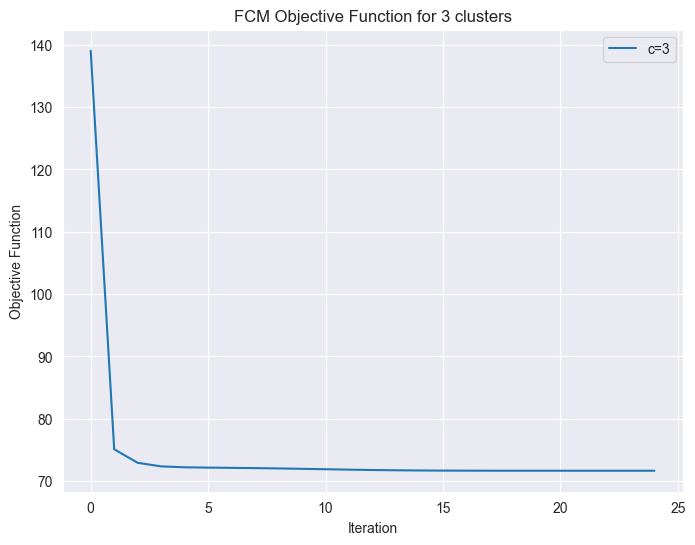

In [100]:
import matplotlib.pyplot as plt
from function import *
import skfuzzy as fuzz

def FCM_cost_function(X, c, m, error, maxiter):
    '''
    Args:
    X : data, size (p, n), n samples of p features.
    c : number of clusters.
    m : Weighting exponent (Fuzziness degree).
    error : Stopping criterion; stop early if the norm of (u[p] - u[p-1]) < error.
    maxiter : Maximum number of iterations allowed.
    jm : Objective function.
    '''
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        df_normalized.T, c, m, error, max_iterations,metric='euclidean', init=U_transpose)
    return jm

# Data & Parameters
c_min = 2
c_max = 5
c=3
m = 2.0
error = 0.005
max_iterations = 100 #teacher said its too high

# Plotting cost functions for different c
plt.figure(figsize=(8, 6))
jm = FCM_cost_function(df_normalized, c, m, error, max_iterations)
plt.plot(jm, label=f'c={c}')  # Plot cost function with label c

#for c in range(c_min, c_max + 1):
 #   jm = FCM_cost_function(df_normalized, c, m, error, max_iterations)
  #  plt.plot(jm, label=f'c={c}')  # Plot cost function with label c

plt.xlabel('Iteration')
plt.ylabel('Objective Function')

#plt.title('FCM Objective Function for Different Number of Clusters')
plt.title('FCM Objective Function for 3 clusters')

plt.legend(loc='best')  # Add legend to differentiate each line
plt.grid(True)
plt.show()